# Training Baseline

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
import torch.quantization as tq
from torchvision import datasets, transforms
from tqdm import tqdm
import os

In [2]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Loading Dataset
- MNIST
- train, validation and test-datasets

In [31]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download MNIST
full_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Split: 50k train / 10k validation
train_size = 4_200
val_size = 5_000
unused_size = len(full_train) - train_size - val_size

train_dataset, val_dataset, _ = random_split(
    full_train, [train_size, val_size, unused_size]
)

# Dataloaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_calib_loader(num_samples=1000, batch_size=batch_size):
    indices = torch.randperm(len(train_dataset))[:num_samples]
    calib_dataset = Subset(train_dataset, indices)
    calib_loader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
    return calib_loader

calib_loader = get_calib_loader(100)
    

print("train size:", len(train_dataset))
print("val size:", len(val_dataset))
if unused_size > 0:
    print("unused_size:", unused_size)
print("test size:", len(test_dataset))
print("\nbatch size:", batch_size)

train size: 4200
val size: 5000
unused_size: 50800
test size: 10000

batch size: 64


## Model Definition
- The NN-Architecture does not change

In [4]:
class FP32(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias=False)  # bias=False because bn1 has its own bias
        self.bn1 = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()

        # self.fc1 = nn.Linear(9216, 128)
        self.fc1 = nn.Linear(5408, 128)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

## Generic Training and Evaluation Methods

In [5]:
def train_one_epoch(model, loader, optimizer, criterion, epoch_num=1):
    model.train()  # just sets the mode :)
    total_loss = 0.0

    loader_with_tqdm = tqdm(loader, desc=f"Training Epoch {epoch_num}")
    loader_with_tqdm.total = len(loader)

    for x, y in loader_with_tqdm:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    total_time = 0
    avg_time = 0

    # loader_with_tqdm = tqdm(enumerate(loader), desc=f"Evaluating Model")
    # loader_with_tqdm.total = len(loader)

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        start = time.perf_counter()
        out = net(x)
        end = time.perf_counter()

        total_time += end - start
        avg_time += (end - start - avg_time) / (i + 1)
        
        loss = criterion(out, y)

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    avg_time /= batch_size

    avg_latency_ms = avg_time * 1000
    throughput = 1 / avg_time
    acc = correct / total
    
    return total_loss / len(loader), acc, total_time, avg_latency_ms, throughput

In [7]:
def model_size_mb(model) -> float:
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 ** 2)
    os.remove(tmp.name)
    return size_mb

In [8]:
def test(net, model_name="CNN"):
    test_loss, test_acc, total_time, latency, throughput = evaluate(net, test_loader)
    test_size = model_size_mb(net)

    print(f"-- Evaluating {model_name} --")
    print(f"{model_name} evaluation finished in {total_time:.4f}s")
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Model Size: {test_size:.4f}MB")
    print(f"{model_name} Inference Latency: {latency:.4f}ms")
    print(f"{model_name} Inference Throughput per second: {throughput:.0f}")
    print()

In [67]:
def calculating_avg_latency(net, iterations=10):
    total_avg_lat = 0
    for _ in range(iterations):
        _, _, _, avg, _ = evaluate(net, test_loader)
        total_avg_lat += avg
    avg_latency_ms = total_avg_lat / iterations
    return avg_latency_ms

## Training
- Train once or load if exists (if already trained)

In [32]:
model_path = "./models/fp32.pth"

model = FP32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

val_accuracies = []
epoch_train_times = []

if os.path.exists(model_path):
    print("Loading trained FP32 model from disk...")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

else:
    print("Training FP32 model...")

    for epoch in range(num_epochs):
        
        start = time.time()
        _ = train_one_epoch(
            model, train_loader, optimizer, criterion, epoch_num=epoch+1
        )
        epoch_time = time.time() - start
        
        _, val_acc, _, _, _ = evaluate(
            model, val_loader
        )

        epoch_train_times.append(epoch_time)
        val_accuracies.append(val_acc)

        print(f"Trained Epoch {epoch+1} in {epoch_time} seconds with val_accuracy: {val_acc:.4f}")

    print("Training finished")

    total_training_time = sum(epoch_train_times)
    print(f"Total Time trained: {total_training_time}")
    print(f"Avg. Time per Epoch: {total_training_time / num_epochs}")
    
    torch.save(model.state_dict(), model_path)
    print("Model saved to:", model_path)

Training FP32 model...


Training Epoch 1: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 49.94it/s]


Trained Epoch 1 in 1.3234822750091553 seconds with val_accuracy: 0.9156


Training Epoch 2: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 53.84it/s]


Trained Epoch 2 in 1.2287535667419434 seconds with val_accuracy: 0.9414


Training Epoch 3: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 54.28it/s]


Trained Epoch 3 in 1.2178683280944824 seconds with val_accuracy: 0.9348


Training Epoch 4: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 54.98it/s]


Trained Epoch 4 in 1.2025132179260254 seconds with val_accuracy: 0.9548


Training Epoch 5: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 54.82it/s]


Trained Epoch 5 in 1.2070283889770508 seconds with val_accuracy: 0.9558


Training Epoch 6: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 55.21it/s]


Trained Epoch 6 in 1.1975290775299072 seconds with val_accuracy: 0.9590


Training Epoch 7: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 55.50it/s]


Trained Epoch 7 in 1.1900973320007324 seconds with val_accuracy: 0.9602


Training Epoch 8: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 53.78it/s]


Trained Epoch 8 in 1.2292978763580322 seconds with val_accuracy: 0.9596


Training Epoch 9: 100%|████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 55.53it/s]


Trained Epoch 9 in 1.1916413307189941 seconds with val_accuracy: 0.9604


Training Epoch 10: 100%|███████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 55.64it/s]


Trained Epoch 10 in 1.1872296333312988 seconds with val_accuracy: 0.9604
Training finished
Total Time trained: 12.175441026687622
Avg. Time per Epoch: 1.2175441026687621
Model saved to: ./models/fp32.pth


## Evaluation
- generic method

In [10]:
test(model, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.5508s
PTQ Naive Test Accuracy: 0.9582
PTQ Naive Model Size: 2.6512MB
PTQ Naive Inference Latency: 0.0548ms
PTQ Naive Inference Throughput per second: 18241



## Experiments

In [11]:
print(len(train_loader))
print(len(test_loader) * batch_size)

47
10048


# PTQ (Naive)

In [12]:
class NaivePTQ(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()  # introduces observers
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x

In [13]:
net_ptq_naive = NaivePTQ().to(device)
net_ptq_naive.load_state_dict(model.state_dict())
net_ptq_naive.eval()

net_ptq_naive.qconfig = torch.ao.quantization.default_qconfig
net_ptq_naive = torch.ao.quantization.prepare(net_ptq_naive)  # insert observers for callibration / MinMaxObservers
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(
    in_features=5408, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
)

### Callibrate with evaluation

In [14]:
# calibration
evaluate(net_ptq_naive, calib_loader)

(0.0026195072568953037,
 1.0,
 0.008057600003667176,
 0.06295000002864981,
 15885.623503492929)

In [15]:
# printing all observed min and max values
net_ptq_naive

NaivePTQ(
  (conv1): Conv2d(
    1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=-0.80129075050354, max_val=1.168089747428894)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=-9.63398551940918, max_val=9.405465126037598)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(
    in_features=5408, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=-27.501049041748047, max_val=31.70554542541504)
  )
  (relu2): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=-16.36876106262207, max_val=20.98222541809082)
  )
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=0.0, max_val=1.0)
  )
  (dequant): DeQuantStub()
)

In [16]:
# actual quantization:
net_ptq_naive = torch.ao.quantization.convert(net_ptq_naive)
net_ptq_naive

NaivePTQ(
  (conv1): QuantizedConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.015506933443248272, zero_point=52, bias=False)
  (bn1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): QuantizedLinear(in_features=5408, out_features=128, scale=0.46619367599487305, zero_point=59, qscheme=torch.per_tensor_affine)
  (relu2): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.2941022515296936, zero_point=56, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

this results in assymatric quantization: Each layer has a scale and a zero_point to quantized the values

### Compare weights with baseline

In [17]:
print(f"Weights of FT32 baseline:")
print(model.conv1.weight[0])
print("\n")
print(f"Quantized Weights of naive_ptq:")
print(torch.int_repr(net_ptq_naive.conv1.weight()[0]))
print("\n")
print(f"Dequantized Weights of naive_ptq:")
print(torch.dequantize(net_ptq_naive.conv1.weight()[0]))

Weights of FT32 baseline:
tensor([[[ 0.1728,  0.2110, -0.0973],
         [-0.2779, -0.2402, -0.2528],
         [ 0.1140,  0.1251,  0.2860]]], grad_fn=<SelectBackward0>)


Quantized Weights of naive_ptq:
tensor([[[ 55,  67, -31],
         [-88, -76, -81],
         [ 36,  40,  91]]], dtype=torch.int8)


Dequantized Weights of naive_ptq:
tensor([[[ 0.1727,  0.2104, -0.0973],
         [-0.2763, -0.2387, -0.2544],
         [ 0.1130,  0.1256,  0.2858]]])


### Evaluate PTQNaive

In [18]:
test(net_ptq_naive, model_name="PTQ Naive")

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.2320s
PTQ Naive Test Accuracy: 0.9582
PTQ Naive Model Size: 0.6691MB
PTQ Naive Inference Latency: 0.0231ms
PTQ Naive Inference Throughput per second: 43305



# PTQ + Bias Correction

- Bias Correction operates layer-wise
- After PTQ a layer computes:
$$
y_q=W_qx_q+b
$$
- The Idea for Bias Correction:
$$
\mathbb{E}[W_qx_q]\neq\mathbb{E}[Wx]
$$
- fix in bias $b$ of NN:
$$
b'=b+\mathbb{E}[Wx]-\mathbb{E}[W_qx_q]
$$
- new output:
$$
y_q=W_qx_q+b'
$$

In [19]:
def collect_layer_outputs(net, loader, layers):
    outputs = {name: [] for name in layers}

    hooks = []

    def make_hook(name):
        def hook(module, inp, out):
            outputs[name].append(out.detach().cpu())
        return hook

    for name, module in net.named_modules():
        if name in layers:
            hooks.append(module.register_forward_hook(make_hook(name)))

    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            net(x)

    for h in hooks:
        h.remove()

    return {k: torch.cat(v, dim=0) for k, v in outputs.items()}

In [20]:
def bias_correction_pre_convert(fp32_model, prepared_model, calib_loader):
    layers = [
        name for name, m in fp32_model.named_modules()
        if isinstance(m, (nn.Conv2d, nn.Linear)) and m.bias is not None
    ]

    fp32_outs = collect_layer_outputs(fp32_model, calib_loader, layers)
    prep_outs = collect_layer_outputs(prepared_model, calib_loader, layers)

    for name in layers:
        fp32 = fp32_outs[name]
        prep = prep_outs[name]

        if fp32.dim() == 4:   # Conv
            delta = (fp32 - prep).mean(dim=(0, 2, 3))
        else:                 # Linear
            delta = (fp32 - prep).mean(dim=0)

        module = dict(prepared_model.named_modules())[name]
        module.bias.data += delta.to(module.bias.device)

    return prepared_model

In [21]:
net_bias = NaivePTQ().to(device)
net_bias.load_state_dict(model.state_dict())
net_bias.eval()

net_bias.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_bias, inplace=True)

NaivePTQ(
  (conv1): Conv2d(
    1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(
    in_features=5408, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
)

In [22]:
fp32_ref = FP32().to(device)
fp32_ref.load_state_dict(model.state_dict())
fp32_ref.eval()

FP32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
net_bias = bias_correction_pre_convert(
    fp32_ref,
    net_bias,
    calib_loader
)

net_bias = torch.ao.quantization.convert(net_bias)

In [24]:
test(net_bias, model_name="PTQ with Bias Correction")

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.2212s
PTQ with Bias Correction Test Accuracy: 0.9582
PTQ with Bias Correction Model Size: 0.6691MB
PTQ with Bias Correction Inference Latency: 0.0220ms
PTQ with Bias Correction Inference Throughput per second: 45435



# PTQ + BN Folding

In [35]:
class PTQ_BN_Folding(FP32):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)  # (Fusion will replace conv1+bn1+relu1 with a single ConvReLU module)
        x = self.dequant(x)
        return x

In [37]:
# Load weights from the trained BN model
net_ptq_fold = PTQ_BN_Folding().to(device)
net_ptq_fold.load_state_dict(model.state_dict())
net_ptq_fold.eval()

PTQ_BN_Folding(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [38]:
# Fusing Conv2d + BatchNorm2d + ReLU
torch.ao.quantization.fuse_modules(
    net_ptq_fold, 
    [['conv1', 'bn1', 'relu1']], 
    inplace=True
)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (bn1): Identity()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): Identity()
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)

In [39]:
# Prepare (Insert Observers)
net_ptq_fold.qconfig = torch.ao.quantization.default_qconfig
torch.ao.quantization.prepare(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (bn1): Identity()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): Identity()
  (fc1): Linear(
    in_features=5408, out_features=128, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu2): ReLU()
  (fc2): Linear(
    in_features=128, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
)

In [40]:
# Calibrate
evaluate(net_ptq_fold, calib_loader)

(0.0016541487129870802,
 1.0,
 0.006810900056734681,
 0.053210156693239696,
 18793.404532993023)

In [41]:
# actual quantization
torch.ao.quantization.convert(net_ptq_fold, inplace=True)

PTQ_BN_Folding(
  (conv1): QuantizedConvReLU2d(1, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.07639258354902267, zero_point=0)
  (bn1): Identity()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): Identity()
  (fc1): QuantizedLinear(in_features=5408, out_features=128, scale=0.4036511182785034, zero_point=57, qscheme=torch.per_tensor_affine)
  (relu2): ReLU()
  (fc2): QuantizedLinear(in_features=128, out_features=10, scale=0.30629250407218933, zero_point=59, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [42]:
# Evaluate
test(net_ptq_fold, model_name="PTQ with BN Folding")

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.1784s
PTQ with BN Folding Test Accuracy: 0.9622
PTQ with BN Folding Model Size: 0.6672MB
PTQ with BN Folding Inference Latency: 0.0178ms
PTQ with BN Folding Inference Throughput per second: 56313



# Mixed Precision PTQ 

In [71]:
def get_layer_sensitivity(fp32_model, quantized_model, loader):
    """
    Compares layer outputs of FP32 vs Quantized model to find the most sensitive layers.
    """
    fp32_model.eval()
    quantized_model.eval()
    
    # We only care about weighted layers
    target_layers = [nn.Conv2d, nn.Linear]
    
    # Store outputs here
    outputs_fp32 = {}
    outputs_quant = {}
    
    # --- Hooks ---
    def save_output(container, name):
        def hook(module, inp, out):
            # If output is quantized (quint8), dequantize it for comparison
            if out.is_quantized:
                out = out.dequantize()
            container[name] = out.detach().cpu()
        return hook

    # Register hooks
    handles = []
    for name, mod in fp32_model.named_modules():
        if isinstance(mod, tuple(target_layers)):
            handles.append(mod.register_forward_hook(save_output(outputs_fp32, name)))
            
    for name, mod in quantized_model.named_modules():
        if isinstance(mod, tuple(target_layers)):
            handles.append(mod.register_forward_hook(save_output(outputs_quant, name)))

    # --- Run Inference (1 Batch is usually enough) ---
    x, _ = next(iter(loader))
    x = x.to(device)
    
    with torch.no_grad():
        fp32_model(x)
        quantized_model(x)

    # --- Cleanup Hooks ---
    for h in handles:
        h.remove()

    # --- Calculate MSE Error ---
    layer_scores = {}
    for name in outputs_fp32.keys():
        if name in outputs_quant:
            # MSE: Mean Squared Error
            diff = (outputs_fp32[name] - outputs_quant[name]).pow(2).mean()
            layer_scores[name] = diff.item()

    return layer_scores

In [70]:
def plot_sensitivity(sensitivity_dict):
    layers = list(sensitivity_dict.keys())
    errors = list(sensitivity_dict.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(layers, errors, color='salmon')
    plt.ylabel('MSE Loss (Sensitivity)')
    plt.title('Layer-wise Quantization Sensitivity (Lower is Better)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Analyzing Layer Sensitivity...


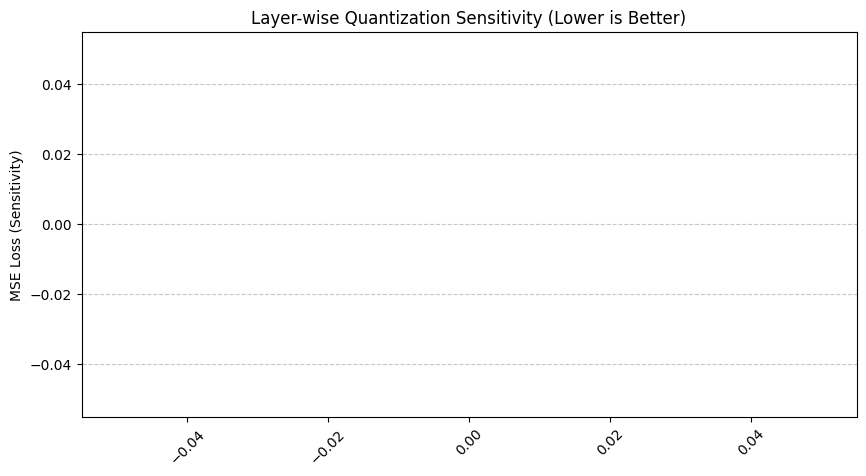


Most Sensitive Layers (High MSE = Bad):


In [72]:
# --- RUN ANALYSIS ---
# Ensure you have your latest models ready:
# 1. model_bn (The FP32 Baseline)
# 2. net_ptq_fold (The Quantized Model)

print("Analyzing Layer Sensitivity...")
sensitivity = get_layer_sensitivity(model, net_ptq_fold, calib_loader)
plot_sensitivity(sensitivity)

# Print sorted most sensitive layers
sorted_layers = sorted(sensitivity.items(), key=lambda item: item[1], reverse=True)
print("\nMost Sensitive Layers (High MSE = Bad):")
for name, score in sorted_layers:
    print(f"{name}: {score:.6f}")

# QAT

# Final Evaluation

In [66]:
test(model, model_name="FP32 Baseline")
test(net_ptq_naive, model_name="PTQ Naive")
test(net_bias, model_name="PTQ with Bias Correction")
test(net_ptq_fold, model_name="PTQ with BN Folding")

-- Evaluating FP32 Baseline --
FP32 Baseline evaluation finished in 0.4786s
FP32 Baseline Test Accuracy: 0.9627
FP32 Baseline Model Size: 2.6512MB
FP32 Baseline Inference Latency: 0.0476ms
FP32 Baseline Inference Throughput per second: 20995

-- Evaluating PTQ Naive --
PTQ Naive evaluation finished in 0.2002s
PTQ Naive Test Accuracy: 0.9582
PTQ Naive Model Size: 0.6691MB
PTQ Naive Inference Latency: 0.0199ms
PTQ Naive Inference Throughput per second: 50191

-- Evaluating PTQ with Bias Correction --
PTQ with Bias Correction evaluation finished in 0.1944s
PTQ with Bias Correction Test Accuracy: 0.9582
PTQ with Bias Correction Model Size: 0.6691MB
PTQ with Bias Correction Inference Latency: 0.0193ms
PTQ with Bias Correction Inference Throughput per second: 51685

-- Evaluating PTQ with BN Folding --
PTQ with BN Folding evaluation finished in 0.1892s
PTQ with BN Folding Test Accuracy: 0.9622
PTQ with BN Folding Model Size: 0.6672MB
PTQ with BN Folding Inference Latency: 0.0188ms
PTQ with B

In [68]:
print(f"FP32 latency: {calculating_avg_latency(model):.4f}ms")
print(f"PTQ Naive latency: {calculating_avg_latency(net_ptq_naive):.4f}ms")
print(f"PTQ Bias Correction latency: {calculating_avg_latency(net_bias):.4f}ms")
print(f"PTQ BN Folding latency: {calculating_avg_latency(net_ptq_fold):.4f}ms")

FP32 latency: 0.0507ms
PTQ Naive latency: 0.0204ms
PTQ Bias Correction latency: 0.0222ms
PTQ BN Folding latency: 0.0175ms
